# Sktime workshop: Pycon Colombia 2025 (Part 3)


![](imgs/sktime-logo.png)

```mermaid

graph TD
  root["__total"]

  %% group -1
  root --> g_minus1["-1"]
  g_minus1 --> sku20["20"]
  g_minus1 --> sku21["21"]
  g_minus1 --> sku22["22"]
  g_minus1 --> sku23["23"]
  g_minus1 --> sku24["24"]

  %% group 0
  root --> g0["0"]
  g0 --> sku0["0"]
  g0 --> sku1["1"]
  g0 --> sku2["2"]
  g0 --> sku3["3"]
  g0 --> sku4["4"]

  %% group 1
  root --> g1["..."]

  
  %% group 3
  root --> g3["3"]
  g3 --> sku15["15"]
  g3 --> sku16["16"]
  g3 --> sku17["17"]
  g3 --> sku18["18"]
  g3 --> sku19["19"]
```


3. **Forecasting hierarchical data with sktime** (20 min)
   1. Data representation for hierarchical data
   2. Reconciliation methods

## 3.1. Loading the data

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_60941/582074409.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from pycon_workshop.dataset import PyConWorkshopDataset

dataset = PyConWorkshopDataset("hierarchical")
y_train, y_test = dataset.load("y_train", "y_test")

In [3]:
y_train

sales
group_id sku_id  date             
-1       20      2020-01-01      0
                 2020-01-02      0
                 2020-01-03      0
                 2020-01-04      0
                 2020-01-05      2
...                            ...
__total  __total 2024-07-01   2002
                 2024-07-02   1617
                 2024-07-03   1917
                 2024-07-04   2383
                 2024-07-05   2463

[51088 rows x 1 columns]

In [4]:
y_train.index.droplevel(-1).nunique()

31

In sktime, totals have the special keyword `__total`.

In [5]:
y_train.loc[(-1, "__total")].head()

,sales
date,
2020-01-01,4
2020-01-02,2
2020-01-03,3
2020-01-04,14
2020-01-05,16


In [6]:
y_train.loc[("__total", "__total")]

,sales
date,
2020-01-01,24
2020-01-02,19
2020-01-03,14
2020-01-04,23
2020-01-05,23
...,...
2024-07-01,2002
2024-07-02,1617
2024-07-03,1917


In [7]:
y_train.index.droplevel(-1).nunique()

31

## 3.2. Forecasting

In [8]:
fh = y_test.index.get_level_values(-1).unique()

In [9]:
from prophetverse import Prophetverse, PiecewiseLinearTrend, MAPInferenceEngine, LinearFourierSeasonality


forecaster = Prophetverse(
    trend=PiecewiseLinearTrend(changepoint_interval=365),
    exogenous_effects=[
        (
            "seasonality",
            LinearFourierSeasonality(
                sp_list=[365.25, 7],
                fourier_terms_list=[10, 3],
                effect_mode="multiplicative",
                freq="D"
                ),
            None
        )
    ],
    inference_engine=MAPInferenceEngine()
)

In [10]:
parallel_config = {
        "backend:parallel": "joblib",
        "backend:parallel:params": {"backend": "loky", "n_jobs": -1},
}

forecaster.set_config(
    **parallel_config
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning

**Problem: the bottom forecasts and the total forecasts are not coherent.**

In [11]:
from sktime.transformations.hierarchical.aggregate import Aggregator

Aggregator().fit_transform(y_pred) - y_pred

sales
group_id sku_id  date                 
-1       20      2024-07-06   0.000000
                 2024-07-07   0.000000
                 2024-07-08   0.000000
                 2024-07-09   0.000000
                 2024-07-10   0.000000
...                                ...
__total  __total 2024-12-28  20.527588
                 2024-12-29  18.580811
                 2024-12-30  17.465332
                 2024-12-31  16.602295
                 2025-01-01  19.933838

[5580 rows x 1 columns]

## 3.3. Forecast reconciliation

![](imgs/hierarchical_reconciled_vs_not.png)

### Methods

There are different methods to reconcile forecasts in hierarchical time series.
There is no silver bullet, and the best method depends on the data and the context.

#### Bottom-up

<img src="imgs/hierarchical_bottomup.png" alt="Hierarchical Bottom-up" width="450">

#### Top-down (forecast proportions)

<img src="imgs/hierarchical_td_fcst.png" alt="Topdown Forecast" width="900">

#### Optimal reconciliation

The coherence can be translated as linear constraints on the forecasts:

$$
y_{total} = \sum_{i=1}^{n} y_i
$$

This is mathematically equivalent to saying that the coherent forecasts lie in a hyperplane defined by the linear constraints.

![](imgs/coherent_plane.png)

* **OLS** : project the base forecasts into the reconciliation space.
* **Weighted OLS**: project all base forecasts into the reconciliation space, but with different weights.
* **Minimum trace (MinT)**: use the error covariance matrix to find the optimal reconciled forecasts. Called "optimal".



In [12]:
from sktime.transformations.hierarchical.reconcile import (
    BottomUpReconciler,
    TopdownReconciler,
    OptimalReconciler
)

bottom_up = BottomUpReconciler() * forecaster
top_down_fcst = TopdownReconciler() * forecaster
optimal = OptimalReconciler("ols") * forecaster

In [13]:
bottom_up.fit(y_train)
top_down_fcst.fit(y_train)
optimal.fit(y_train)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning

TransformedTargetForecaster(steps=[OptimalReconciler(error_covariance_matrix='ols'),
                                   Prophetverse(exogenous_effects=[('seasonality',
                                                                    LinearFourierSeasonality(effect_mode='multiplicative',
                                                                                             fourier_terms_list=[10,
                                                                                                                 3],
                                                                                             freq='D',
                                                                                             sp_list=[365.25,
                                                                                                      7]),
                                                                    None)],
                                                inference_engine=MAPInferenceEngine(),
                                                trend=PiecewiseLinearTrend(changepoint_interval=365))])

In [14]:
y_pred_bottomup = bottom_up.predict(fh=fh)
y_pred_topdown = top_down_fcst.predict(fh=fh)
y_pred_optimal = optimal.predict(fh=fh)

In [15]:
Aggregator().fit_transform(y_pred_bottomup) - y_pred_bottomup

sales
group_id sku_id  date             
-1       20      2024-07-06    0.0
                 2024-07-07    0.0
                 2024-07-08    0.0
                 2024-07-09    0.0
                 2024-07-10    0.0
...                            ...
__total  __total 2024-12-28    0.0
                 2024-12-29    0.0
                 2024-12-30    0.0
                 2024-12-31    0.0
                 2025-01-01    0.0

[5580 rows x 1 columns]

In this case, there's not a lot of difference between the reconciliation outputs.
But we will see that the bottom-up approach is the most accurate one.

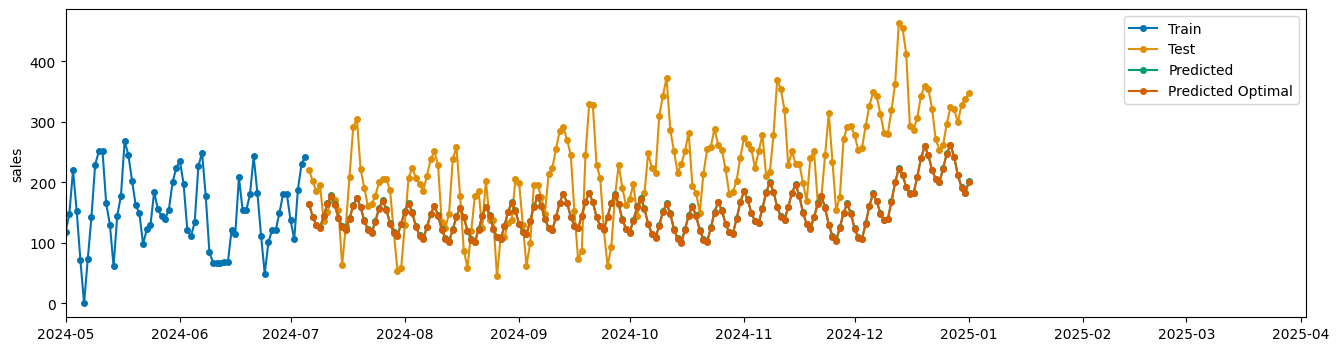

In [16]:
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd


idx = y_train.index.droplevel(-1).unique()[10]

plot_series(
    y_train.loc[idx,], y_test.loc[idx,], y_pred.loc[idx,], y_pred_optimal.loc[idx,],
    labels=["Train", "Test", "Predicted", "Predicted Optimal"],
)
plt.xlim(pd.to_datetime("2024-05-01"), None)
plt.show()

In [17]:
from sktime.forecasting.reconcile import ReconcilerForecaster


mint_forecaster = ReconcilerForecaster(
    forecaster=forecaster,
    method="mint_shrink")

mint_forecaster.fit(y_train)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning: No columns match the regex None
  self._fit_effects(X, y)
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/prophetverse/sktime/univariate.py:244: UserWarning

ReconcilerForecaster(forecaster=Prophetverse(exogenous_effects=[('seasonality',
                                                                 LinearFourierSeasonality(effect_mode='multiplicative',
                                                                                          fourier_terms_list=[10,
                                                                                                              3],
                                                                                          freq='D',
                                                                                          sp_list=[365.25,
                                                                                                   7]),
                                                                 None)],
                                             inference_engine=MAPInferenceEngine(),
                                             trend=PiecewiseLinearTrend(changepoint_interval=365)))

In [18]:
y_pred_mint = mint_forecaster.predict(fh=fh)

In [19]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError(multilevel="uniform_average_time")

pd.DataFrame(
    {   
        "Baseline": metric(y_test, y_pred, y_train=y_train),
        "BottomUpReconciler": metric(y_test, y_pred_bottomup, y_train=y_train),
        "TopDownReconciler": metric(y_test, y_pred_topdown, y_train=y_train),
        "OptimalReconciler (ols)": metric(y_test, y_pred_optimal, y_train=y_train),
        "Mint Reconciler": metric(y_test, y_pred_mint, y_train=y_train),
    },
    index=["Mean Absolute Scaled Error"]
)

,Baseline,BottomUpReconciler,TopDownReconciler,OptimalReconciler (ols),Mint Reconciler
Mean Absolute Scaled Error,44.743985,43.363618,44.81277,44.728172,44.362865
